モデルのトレーニングと評価を開始します
[10/30] train loss: 0.00, valid loss: 0.00
[20/30] train loss: 0.00, valid loss: 0.00
[30/30] train loss: 0.00, valid loss: 0.00
モデルのテストを開始します


0.001658805

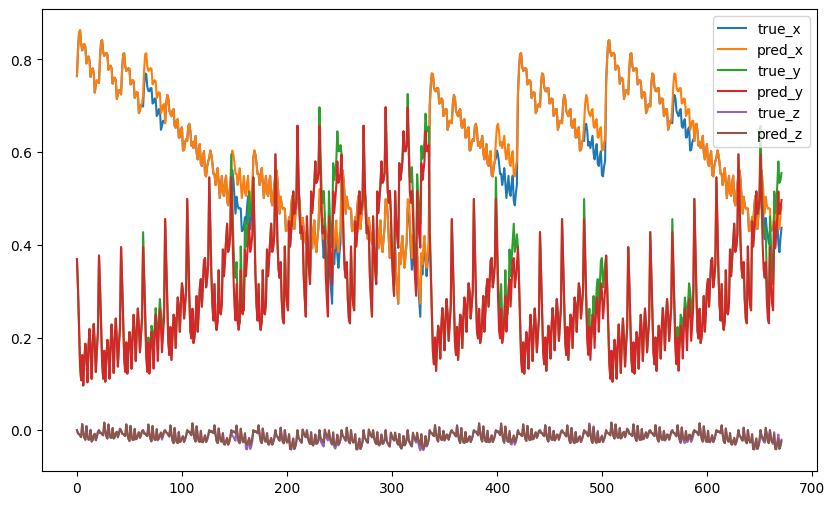

In [19]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.nn import LayerNorm
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.nn import TransformerEncoder, TransformerDecoder, TransformerEncoderLayer, TransformerDecoderLayer
import torch.optim as optim

# デバイスの設定
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# フラットな手の座標をMediaPipe Handランドマークに変換する関数
def flatten_to_landmarks(coordinates):
    landmarks = []
    for i in range(0, len(coordinates), 3):
        landmarks.append((coordinates[i], coordinates[i + 1], coordinates[i + 2]))
    return landmarks

# データの読み込みと前処理
def preprocess_data(csv_path, n_seq, num_joints):
    df = pd.read_csv(csv_path)
    x_data = []
    y_data = []

    for i in range(len(df) - n_seq):
        x_sequence = df.iloc[i:i+n_seq][[f'{j}_{c}' for j in range(num_joints) for c in ['x', 'y', 'z']]].values
        x_data.append(x_sequence)

        y_sequence = df.iloc[i+n_seq][[f'{j}_{c}' for j in range(num_joints) for c in ['x', 'y', 'z']]].values
        y_data.append(y_sequence)

    x_data = np.array(x_data, dtype=np.float32)
    y_data = np.array(y_data, dtype=np.float32)

    return x_data, y_data

# じゃんけんの手のラベル
janken_labels = {0: 'チョキ', 1: 'グー', 2: 'パー'}

# DataLoaderの使用
def create_dataloader(x_train, y_train, batch_size):
    train_dataset = TensorDataset(torch.tensor(x_train, dtype=torch.float32), torch.tensor(y_train, dtype=torch.float32))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    return train_loader

# 位置エンコーディングの定義
class PositionalEncoding(nn.Module):
    def __init__(self, d_model, dropout: float = 0.1, max_len: int = 5000) -> None:
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(p=dropout)
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-math.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0)
        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe[:, :x.size(1)]
        return self.dropout(x)

# モデルに入力するために次元を拡張する
class TokenEmbedding(nn.Module):
    def __init__(self, c_in, d_model):
        super(TokenEmbedding, self).__init__()
        self.tokenConv = nn.Linear(c_in, d_model)

    def forward(self, x):
        x = self.tokenConv(x)
        return x

# Transformerの定義
class Transformer(nn.Module):
    def __init__(self, num_encoder_layers, num_decoder_layers, d_model, d_input, d_output, dim_feedforward=512, dropout=0.1, nhead=8):
        super(Transformer, self).__init__()
        self.token_embedding_x_data = TokenEmbedding(d_input, d_model)
        self.token_embedding_y_data = TokenEmbedding(d_output, d_model)
        self.positional_encoding = PositionalEncoding(d_model, dropout=dropout)
        encoder_layer = TransformerEncoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, activation='gelu')
        encoder_norm = LayerNorm(d_model)
        self.transformer_encoder = TransformerEncoder(encoder_layer, num_layers=num_encoder_layers, norm=encoder_norm)
        decoder_layer = TransformerDecoderLayer(d_model=d_model, nhead=nhead, dim_feedforward=dim_feedforward, dropout=dropout, batch_first=True, activation='gelu')
        decoder_norm = LayerNorm(d_model)
        self.transformer_decoder = TransformerDecoder(decoder_layer, num_layers=num_decoder_layers, norm=decoder_norm)
        self.output = nn.Linear(d_model, d_output)

    def forward(self, x_data, y_data, mask_x_data, mask_y_data):
        embedding_x_data = self.positional_encoding(self.token_embedding_x_data(x_data))
        memory = self.transformer_encoder(embedding_x_data, mask_x_data)
        embedding_y_data = self.positional_encoding(self.token_embedding_y_data(y_data))
        outs = self.transformer_decoder(embedding_y_data, memory, mask_y_data)
        output = self.output(outs)
        return output

    def encode(self, x_data, mask_x_data):
        return self.transformer_encoder(self.positional_encoding(self.token_embedding_x_data(x_data)), mask_x_data)

    def decode(self, y_data, memory, mask_y_data):
        return self.transformer_decoder(self.positional_encoding(self.token_embedding_y_data(y_data)), memory, mask_y_data)

# マスクの定義
def create_mask(x_data, y_data):
    seq_len_x_data = x_data.shape[1]
    seq_len_y_data = y_data.shape[1]
    mask_y_data = generate_square_subsequent_mask(seq_len_y_data).to(device)
    mask_x_data = generate_square_subsequent_mask(seq_len_x_data).to(device)
    return mask_x_data, mask_y_data

def generate_square_subsequent_mask(seq_len):
    mask = torch.triu(torch.full((seq_len, seq_len), float('-inf')), diagonal=1)
    return mask

# 訓練、評価の処理を定義
def train(model, data_provider, optimizer, criterion):
    model.train()
    total_loss = []
    for x_data, y_data in data_provider:
        x_data = x_data.float().to(device)
        y_data = y_data.float().to(device)
        
        # 次元のチェックと拡張
        if x_data.dim() == 2:
            x_data = x_data.unsqueeze(1)
        if y_data.dim() == 2:
            y_data = y_data.unsqueeze(1)
        
        input_y_data = torch.cat((x_data[:, -1:, :], y_data[:, :-1, :]), dim=1)
        mask_x_data, mask_y_data = create_mask(x_data, input_y_data)
        output = model(x_data=x_data, y_data=input_y_data, mask_x_data=mask_x_data, mask_y_data=mask_y_data)
        optimizer.zero_grad()
        loss = criterion(output, y_data)
        loss.backward()
        total_loss.append(loss.cpu().detach())
        optimizer.step()
    return np.average(total_loss)

def evaluate(flag, model, data_provider, criterion):
    model.eval()
    total_loss = []
    all_true = []
    all_pred = []
    for x_data, y_data in data_provider:
        x_data = x_data.float().to(device)
        y_data = y_data.float().to(device)
        
        # 次元のチェックと拡張
        if x_data.dim() == 2:
            x_data = x_data.unsqueeze(1)
        if y_data.dim() == 2:
            y_data = y_data.unsqueeze(1)

        seq_len_x_data = x_data.shape[1]
        mask_x_data = (torch.zeros(seq_len_x_data, seq_len_x_data)).type(torch.bool)
        mask_x_data = mask_x_data.float().to(device)
        memory = model.encode(x_data, mask_x_data)
        outputs = x_data[:, -1:, :]
        seq_len_y_data = y_data.shape[1]
        for i in range(seq_len_y_data - 1):
            mask_y_data = (generate_square_subsequent_mask(outputs.size(1))).to(device)
            output = model.decode(outputs, memory, mask_y_data)
            output = model.output(output)
            outputs = torch.cat([outputs, output[:, -1:, :]], dim=1)
        loss = criterion(outputs, y_data)
        total_loss.append(loss.cpu().detach())
        all_true.append(torch.cat((x_data, y_data), dim=1).cpu().detach().numpy())
        all_pred.append(torch.cat((x_data, outputs), dim=1).cpu().detach().numpy())
    if flag == 'test':
        true = np.concatenate(all_true)
        pred = np.concatenate(all_pred)
        df_true = pd.DataFrame(true.reshape(-1, 3), columns=['8_x', '8_y', '8_z'])
        df_pred = pd.DataFrame(pred.reshape(-1, 3), columns=['8_x', '8_y', '8_z'])
        df_true.to_csv('true_coordinates.csv', index=False)
        df_pred.to_csv('predicted_coordinates.csv', index=False)
        plt.figure(figsize=(10, 6))
        plt.plot(df_true['8_x'], label='true_x')
        plt.plot(df_pred['8_x'], label='pred_x')
        plt.plot(df_true['8_y'], label='true_y')
        plt.plot(df_pred['8_y'], label='pred_y')
        plt.plot(df_true['8_z'], label='true_z')
        plt.plot(df_pred['8_z'], label='pred_z')
        plt.legend()
        plt.savefig('test_coordinates.pdf')
    return np.average(total_loss)

# パラメータなどの定義
d_input = 3
d_output = 3
d_model = 512
nhead = 8
dim_feedforward = 2048
num_encoder_layers = 1
num_decoder_layers = 1
dropout = 0.01
x_data_len = 36
y_data_len = 12
batch_size = 1
epochs = 30
best_loss = float('Inf')
best_model = None

n_seq = 3
num_joints = 21
input_size = num_joints * 3
hidden_size = 16
output_size = num_joints * 3
num_layers = 1
n_epochs = 100

print("モデルのトレーニングと評価を開始します")

train_csv_path = 'hand_300.csv'
test_csv_path = 'test_10/choki_test_10/choki_test.csv'

x_train, y_train = preprocess_data(train_csv_path, n_seq, num_joints)
x_test, y_test = preprocess_data(test_csv_path, n_seq, num_joints)

train_loader = create_dataloader(x_train, y_train, batch_size)

model = Transformer(num_encoder_layers=num_encoder_layers, num_decoder_layers=num_decoder_layers, d_model=d_model, d_input=num_joints * 3, d_output=num_joints * 3, dim_feedforward=dim_feedforward, dropout=dropout, nhead=nhead)

for p in model.parameters():
    if p.dim() > 1:
        nn.init.xavier_uniform_(p)

model = model.to(device)
criterion = torch.nn.MSELoss()
optimizer = torch.optim.RAdam(model.parameters(), lr=0.0001)

valid_losses = []
for epoch in range(1, epochs + 1):
    loss_train = train(model=model, data_provider=train_loader, optimizer=optimizer, criterion=criterion)
    loss_valid = evaluate(flag='val', model=model, data_provider=create_dataloader(x_test, y_test, batch_size), criterion=criterion)
    if epoch % 10 == 0:
        print('[{}/{}] train loss: {:.2f}, valid loss: {:.2f}'.format(epoch, epochs, loss_train, loss_valid))
    valid_losses.append(loss_valid)
    if best_loss > loss_valid:
        best_loss = loss_valid
        best_model = model

print("モデルのテストを開始します")
evaluate(flag='test', model=best_model, data_provider=create_dataloader(x_test, y_test, batch_size), criterion=criterion)
